# Comparison of DE genes in genome-wide screens for different cell types

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import zarr
import scipy
import pertpy
# import rapids_singlecell

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


from tqdm.notebook import tqdm

In [33]:
import yaml
with open('../../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)
palettes.keys()

dict_keys(['culture_condition', 'n_donors', 'matched_targets'])

## Load MASH DE results
Generated in `K562_DEseq2.ipynb`

In [4]:
all_res_df = pd.read_parquet('/mnt/oak/users/emma/data/GWT/CD4i_final/MASH_comparison_results.parquet')

In [5]:
split_test_df = all_res_df.test.str.split("_", expand=True).rename(columns={0: "target_contrast", 1: "gene_name"})

In [6]:
all_res_df = pd.concat([all_res_df, split_test_df], axis=1)

In [7]:
all_res_df['cell_type'] = np.where(all_res_df['index'] == 'log_fc', 'K562', all_res_df['index'])
all_res_df = all_res_df.drop(['model_key', 'index'], axis=1)

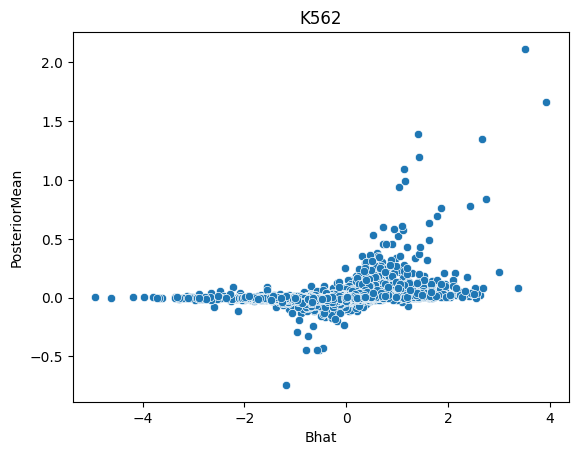

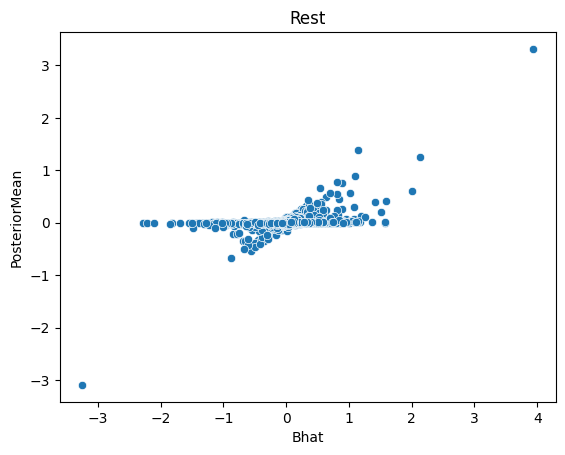

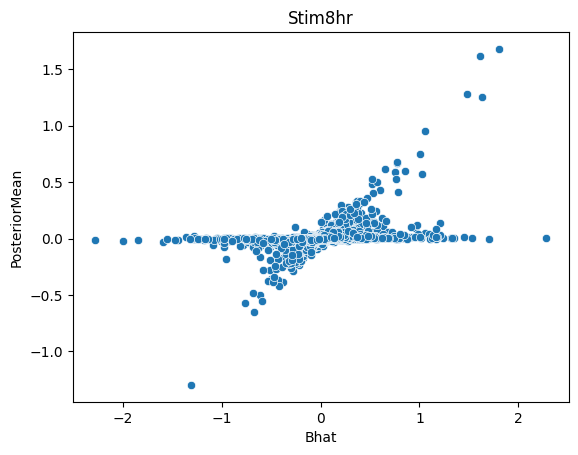

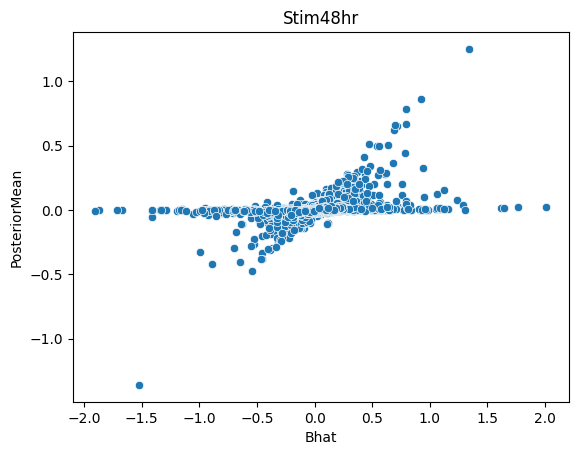

In [8]:
for ct in all_res_df['cell_type'].unique():
    sns.scatterplot(data=all_res_df[all_res_df.cell_type == ct].sample(10000), x='Bhat', y='PosteriorMean')
    plt.title(ct)
    plt.show()

### Visualize overlap in DE genes

In [9]:
signif_res_df = all_res_df[all_res_df['lfsr'] < 0.05]
wide_signif_res_df = signif_res_df.pivot(columns='cell_type', index=['target_contrast', 'gene_name'], values='PosteriorMean')

/tmp/ipykernel_3088420/2587905130.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


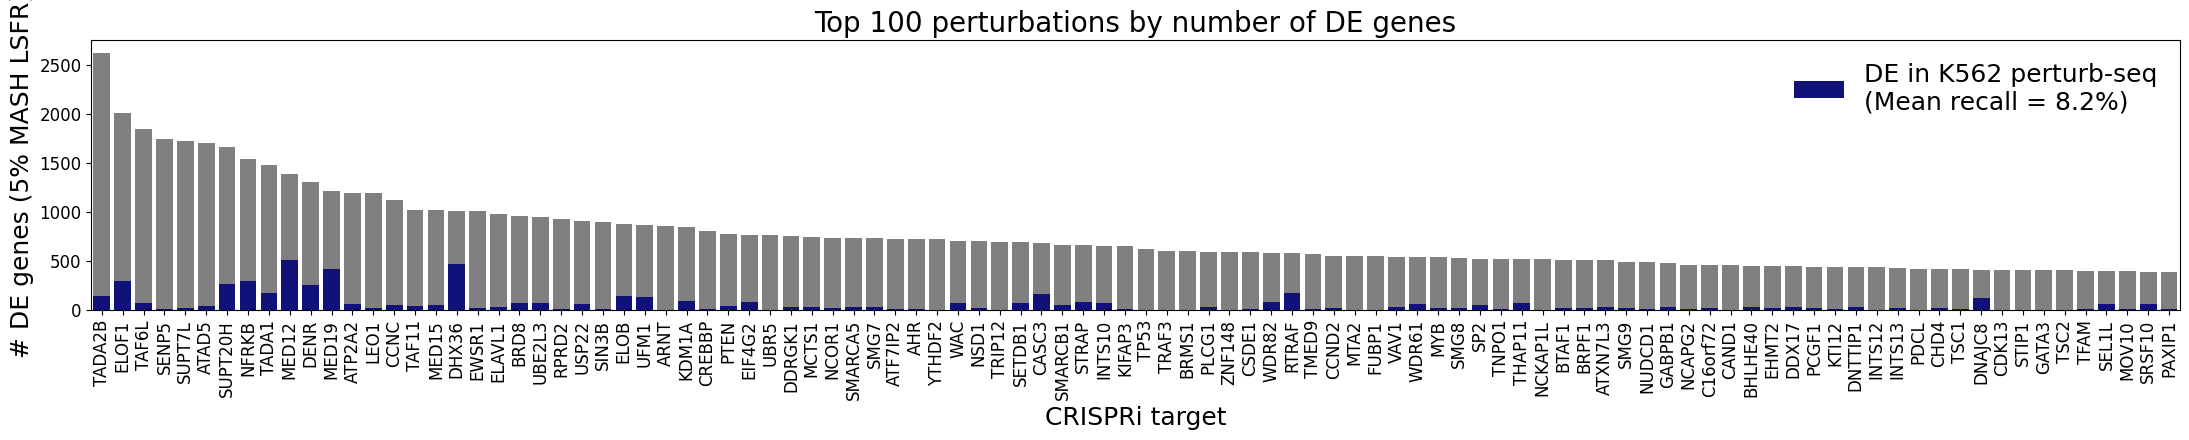

/tmp/ipykernel_3088420/2587905130.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


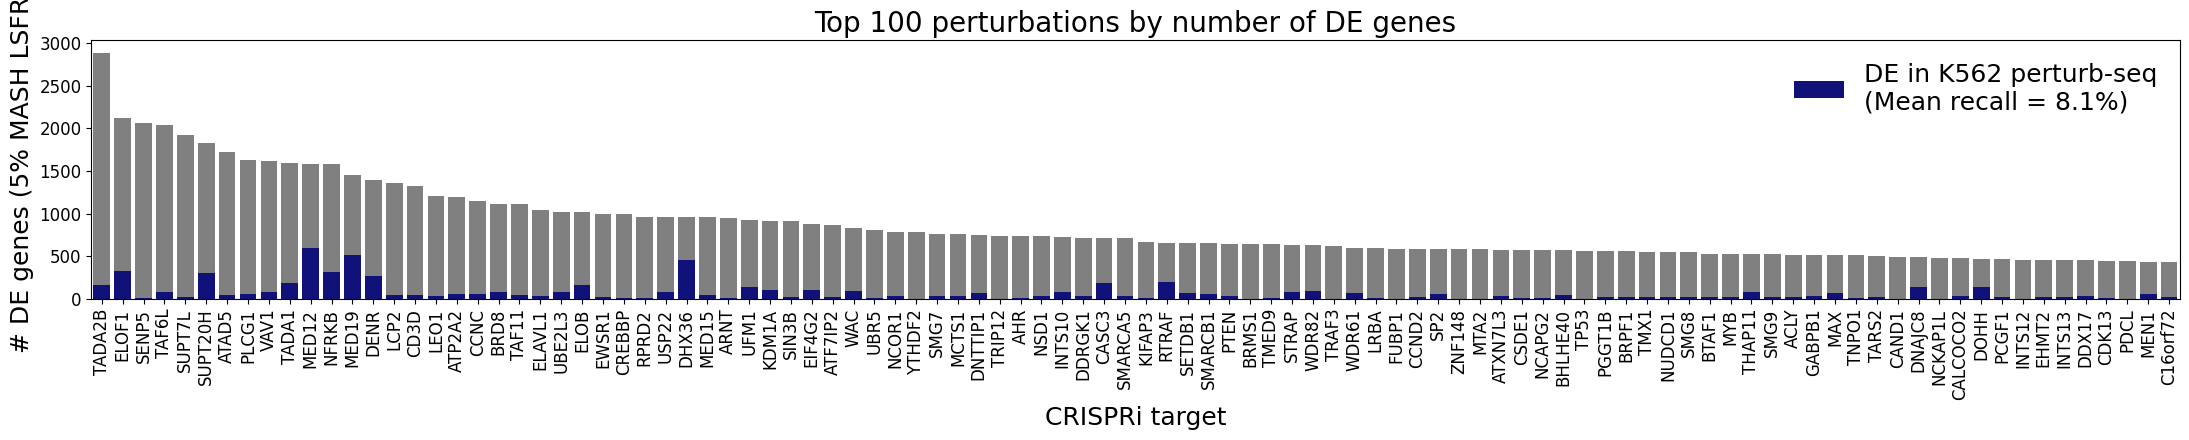

/tmp/ipykernel_3088420/2587905130.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)


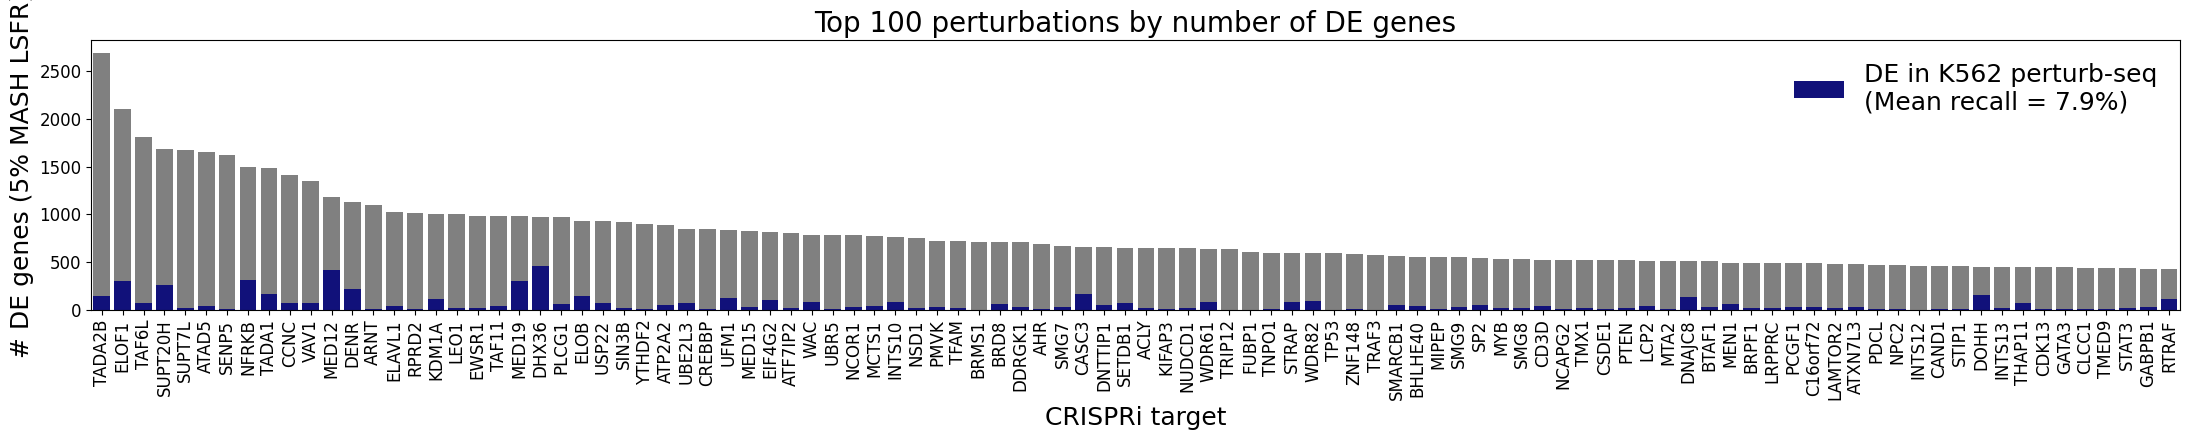

In [10]:
tcells_de_compare_dict = {}
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    signif_df = (wide_signif_res_df[['K562', c]]
        .groupby('target_contrast')
        .apply(lambda x: pd.Series({
            'K562_repl': ((~x['K562'].isna()) & (~x[c].isna())).sum(),
            'n_signif': (~x[c].isna()).sum()
        })))
    signif_df = signif_df.sort_values('n_signif', ascending=False)

    # Take top 100 perturbations
    pl_signif_df = signif_df.head(100)

    # Create single figure
    fig, ax = plt.subplots(figsize=(22, 4.5))

    # Plot bars
    sns.barplot(data=pl_signif_df, x='target_contrast', y='n_signif', ax=ax, color='grey')
    sns.barplot(data=pl_signif_df, x='target_contrast', y='K562_repl', ax=ax, color='darkblue', 
                label=f'DE in K562 perturb-seq\n(Mean recall = {np.round(np.mean(signif_df["K562_repl"]/signif_df["n_signif"]) * 100, 1)}%)')

    # Customize plot
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
    ax.set_ylabel('# DE genes (5% MASH LSFR)', fontsize=18)
    ax.set_xlabel('CRISPRi target', fontsize=18)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(frameon=False, fontsize=18)

    plt.title('Top 100 perturbations by number of DE genes', fontsize=20)
    plt.tight_layout()
    plt.show()

In [179]:
wide_signif_res_df.reset_index()['target_contrast'].nunique()

2670

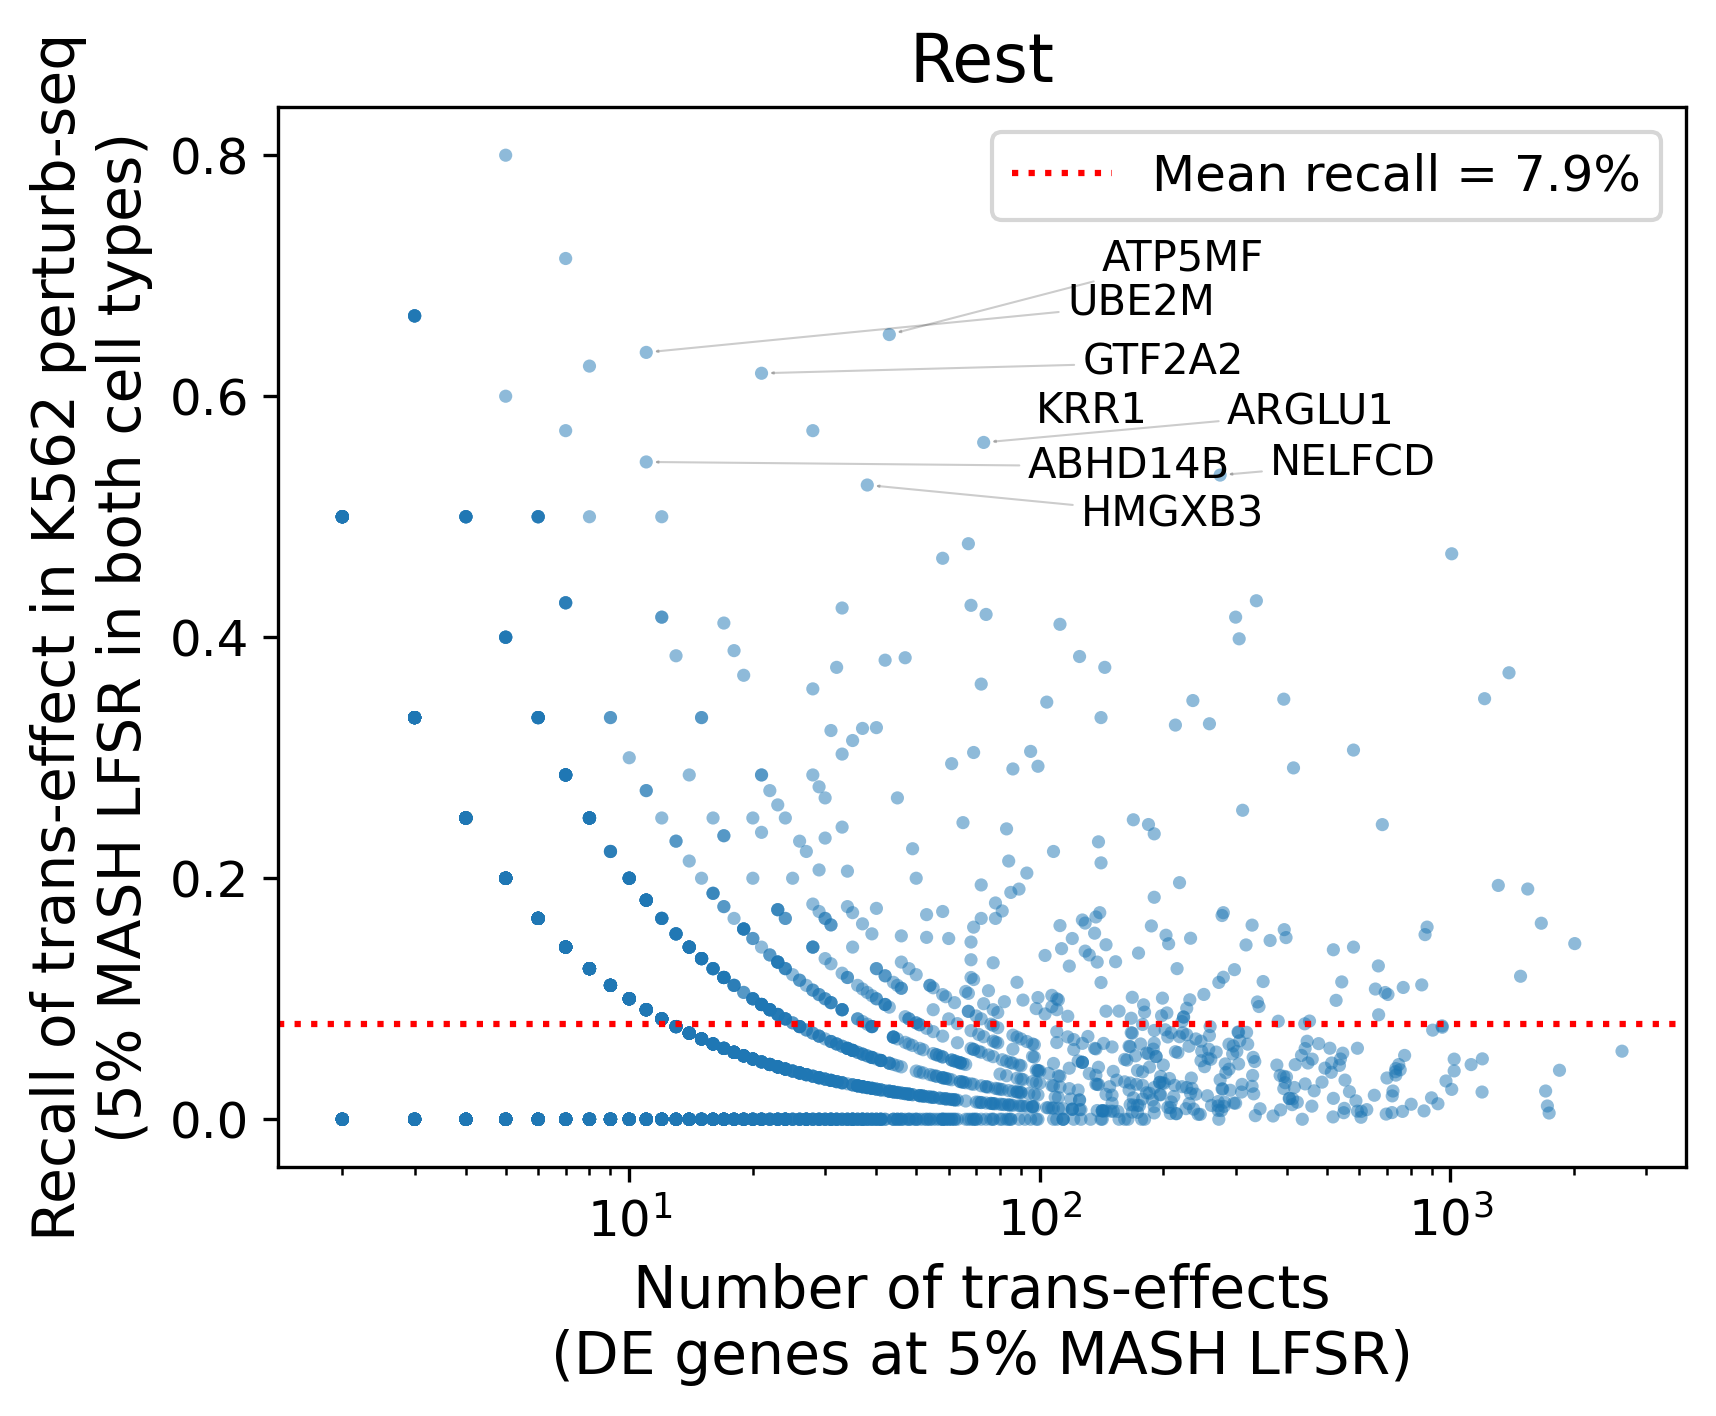

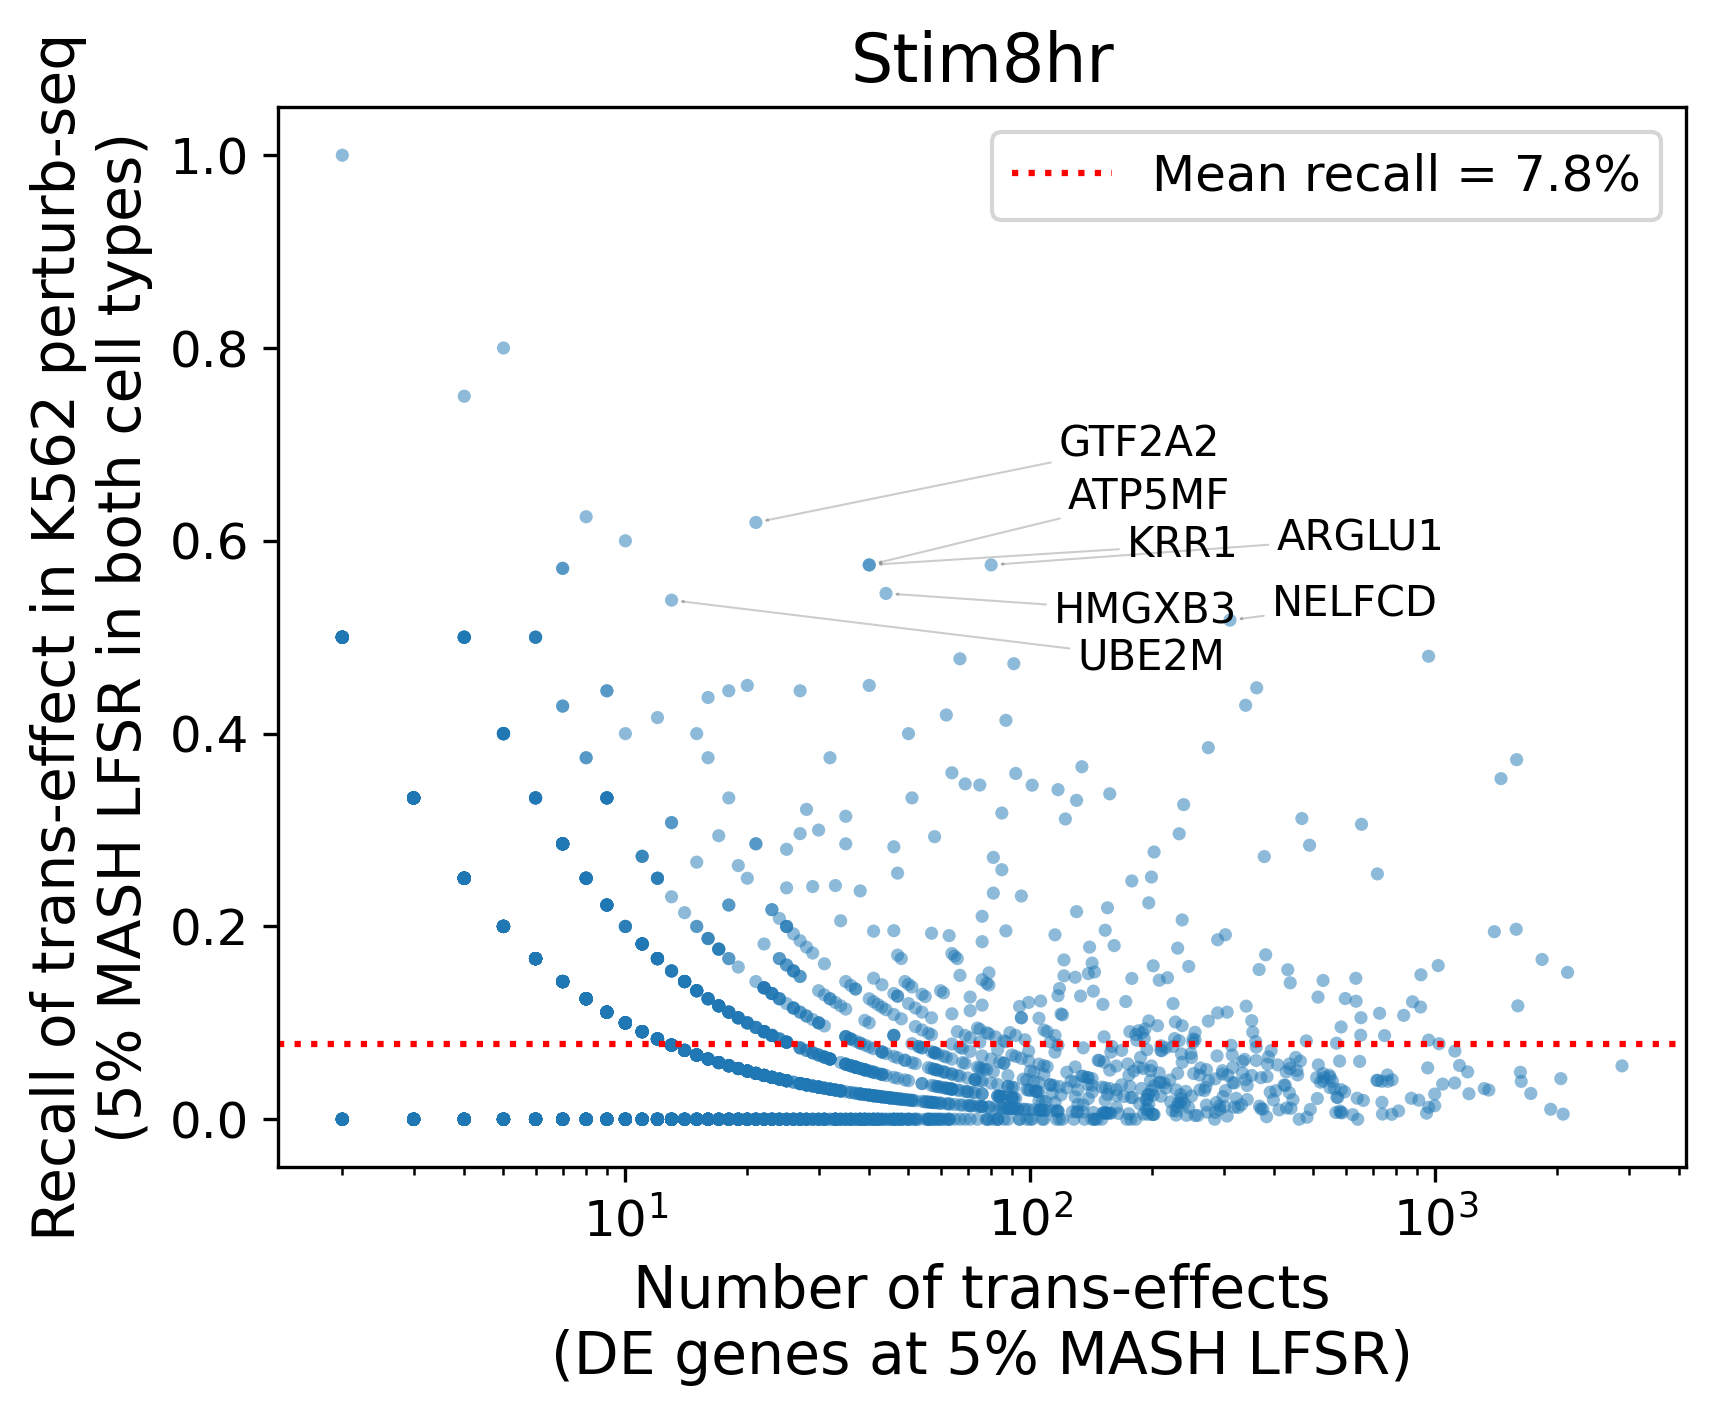

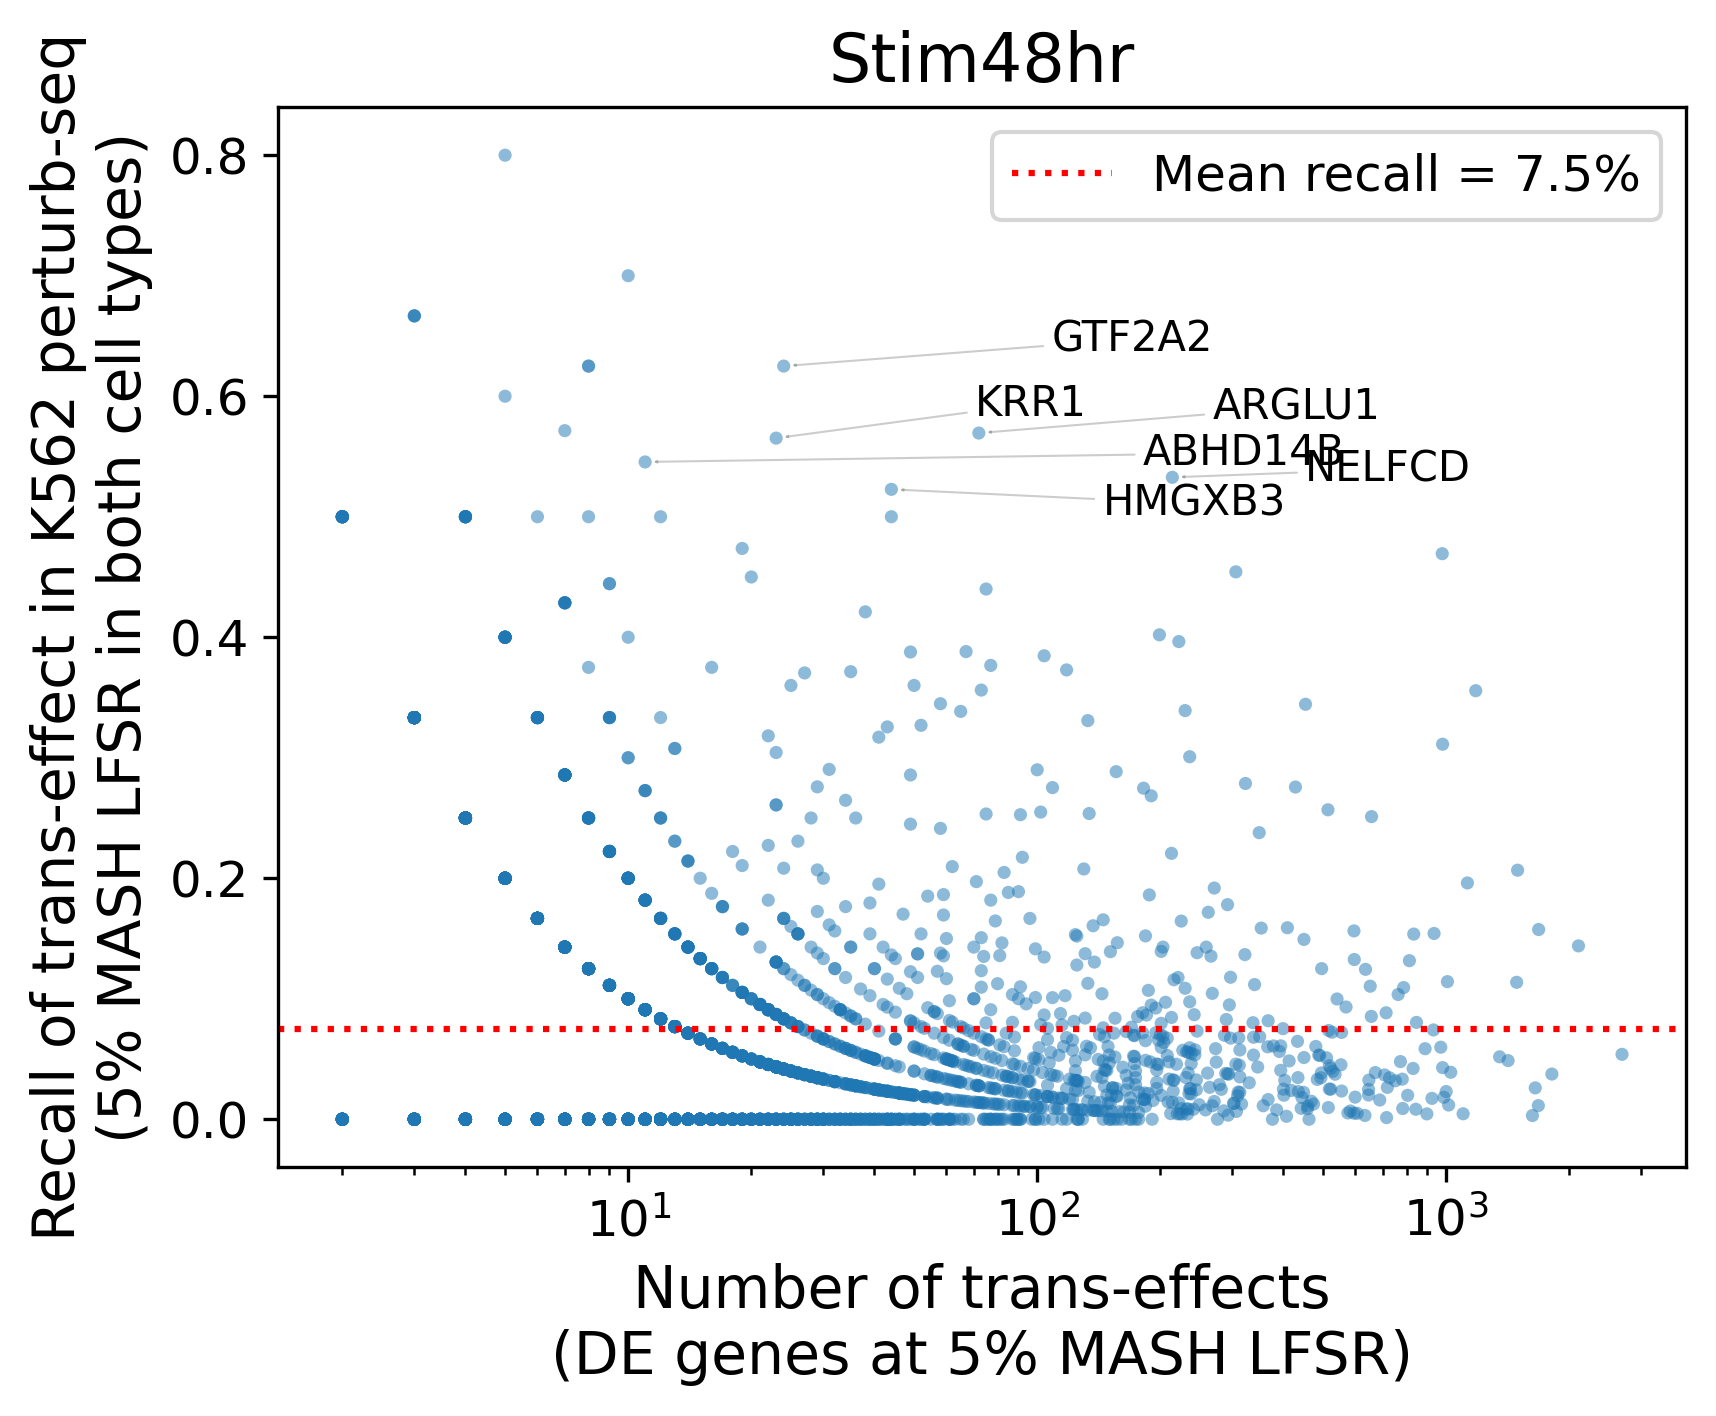

In [36]:
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    # Compute recall of DE genes with K562
    signif_df = (wide_signif_res_df[['K562', c]]
        .groupby('target_contrast')
        .apply(lambda x: pd.Series({
            'K562_repl': ((~x['K562'].isna()) & (~x[c].isna())).sum(),
            'n_signif': (~x[c].isna()).sum()
        })))
    signif_df = signif_df.sort_values('n_signif', ascending=False)
    tot_de = signif_df[signif_df['n_signif'] > 1]['n_signif']
    recall_k562 = signif_df[signif_df['n_signif'] > 1]['K562_repl']/signif_df[signif_df['n_signif'] > 1]['n_signif']
    mean_recall = recall_k562.mean()

    plt.figure(figsize=(6,5))
    sns.scatterplot(x=tot_de, y=recall_k562, edgecolor='none', alpha=0.5, s=10)

    # Add mean recall line
    plt.axhline(y=mean_recall, color='red', linestyle=':', label=f'Mean recall = {(mean_recall*100):.1f}%')

    # Add annotations for genes with low recall and high effects
    # Filter signif_df for points meeting annotation criteria
    annot_df = signif_df[(signif_df['n_signif'] > 10) & (signif_df['K562_repl']/signif_df['n_signif'] > 0.5)]
    
    texts = [plt.annotate(idx, xy=(row['n_signif'], row['K562_repl']/row['n_signif']),fontsize=10) for idx, row in annot_df.iterrows()]

    # Use adjustText to prevent text overlaps
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5, alpha=0.2))

    plt.xscale('log')
    plt.xlabel('Number of trans-effects\n(DE genes at 5% MASH LFSR)', fontsize=14)
    plt.ylabel('Recall of trans-effect in K562 perturb-seq\n(5% MASH LFSR in both cell types)', fontsize=14)
    plt.title(f'{c}', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'./results/recall_scatterplot.{c}.pdf')
    plt.savefig(f'./results/recall_scatterplot.{c}.png')
    plt.show()


## Compare effect size

In [37]:
# Keep targets with at least some significant effect in all datasets
n_de_genes_ct = signif_res_df.value_counts(['cell_type', 'target_contrast']).reset_index().pivot(columns='cell_type', index='target_contrast', values='count').fillna(0)
keep_targets = n_de_genes_ct[n_de_genes_ct.gt(2).all(axis=1)].index.tolist()

In [180]:
len(keep_targets)

1880

In [38]:
k562_de_compare = all_res_df[all_res_df.cell_type == 'K562'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")
rest_de_compare = all_res_df[all_res_df.cell_type == 'Rest'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")
stim_de_compare = all_res_df[all_res_df.cell_type == 'Stim8hr'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")
stim48_de_compare = all_res_df[all_res_df.cell_type == 'Stim48hr'].pivot(columns='target_contrast', index='gene_name', values="PosteriorMean")

In [39]:
k562_de_compare = k562_de_compare.mask(k562_de_compare.index.values[:, None] == k562_de_compare.columns.values).fillna(0)[keep_targets]
rest_de_compare = rest_de_compare.mask(rest_de_compare.index.values[:, None] == rest_de_compare.columns.values).fillna(0)[keep_targets]
stim_de_compare = stim_de_compare.mask(k562_de_compare.index.values[:, None] == stim_de_compare.columns.values).fillna(0)[keep_targets]
stim48_de_compare = stim48_de_compare.mask(k562_de_compare.index.values[:, None] == stim48_de_compare.columns.values).fillna(0)[keep_targets]

In [ ]:
# Define the comparisons we want to make
comparisons = [
    ('K562 vs CD4+T (Rest)', k562_de_compare, rest_de_compare),
    ('K562 vs CD4+T (Stim 8hr)', k562_de_compare, stim_de_compare),
    ('K562 vs CD4+T (Stim 48hr)', k562_de_compare, stim48_de_compare),
    ('CD4+T (Stim 8hr) vs CD4+T (Rest)', stim_de_compare, rest_de_compare),
    ('CD4+T (Stim 8hr) vs CD4+T (Stim 48hr)', stim_de_compare, stim48_de_compare),
    ('CD4+T (Stim 48hr) vs CD4+T (Rest)', stim48_de_compare, rest_de_compare)
]

comparison_results = {}

for comparison_name, df1, df2 in comparisons:
    results_df = pd.DataFrame(columns=['Perturbation', 'pearson_r', 'pearson_pval', 
                                      'random_r1', 'random_r2', 'random_r3'])
    
    for perturb in df1.columns:
        values1 = df1[perturb]
        values2 = df2[perturb]
        
        # Calculate correlation for the same perturbation
        corr = scipy.stats.pearsonr(values1, values2)
        
        # Calculate random correlations (shuffling column labels 3 times)
        random_rs = []
        for _ in range(3):
            random_perturb = np.random.choice(df1.columns)
            random_values = df2[random_perturb]
            random_corr = scipy.stats.pearsonr(values1, random_values)
            random_rs.append(random_corr.statistic)
        
        new_row = pd.DataFrame({
            'Perturbation': [perturb],
            'pearson_r': [corr.statistic],
            'pearson_pval': [corr.pvalue],
            'random_r1': [random_rs[0]],
            'random_r2': [random_rs[1]],
            'random_r3': [random_rs[2]]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    
    results_df = results_df.sort_values('pearson_r', ascending=False)
    comparison_results[comparison_name] = results_df

correlation_results = pd.concat([v.assign(comparison=k) for k,v in comparison_results.items()])

/tmp/ipykernel_3088420/4066855837.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/tmp/ipykernel_3088420/4066855837.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/tmp/ipykernel_3088420/4066855837.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty o

In [185]:
print("K562 comparisons median:", correlation_results[correlation_results.comparison.str.contains('K562')].pearson_r.mean())
print("CD4 comparisons median:", correlation_results[~correlation_results.comparison.str.contains('K562')].pearson_r.mean())

K562 comparisons median: 0.3225498053131778
CD4 comparisons median: 0.909521883298543


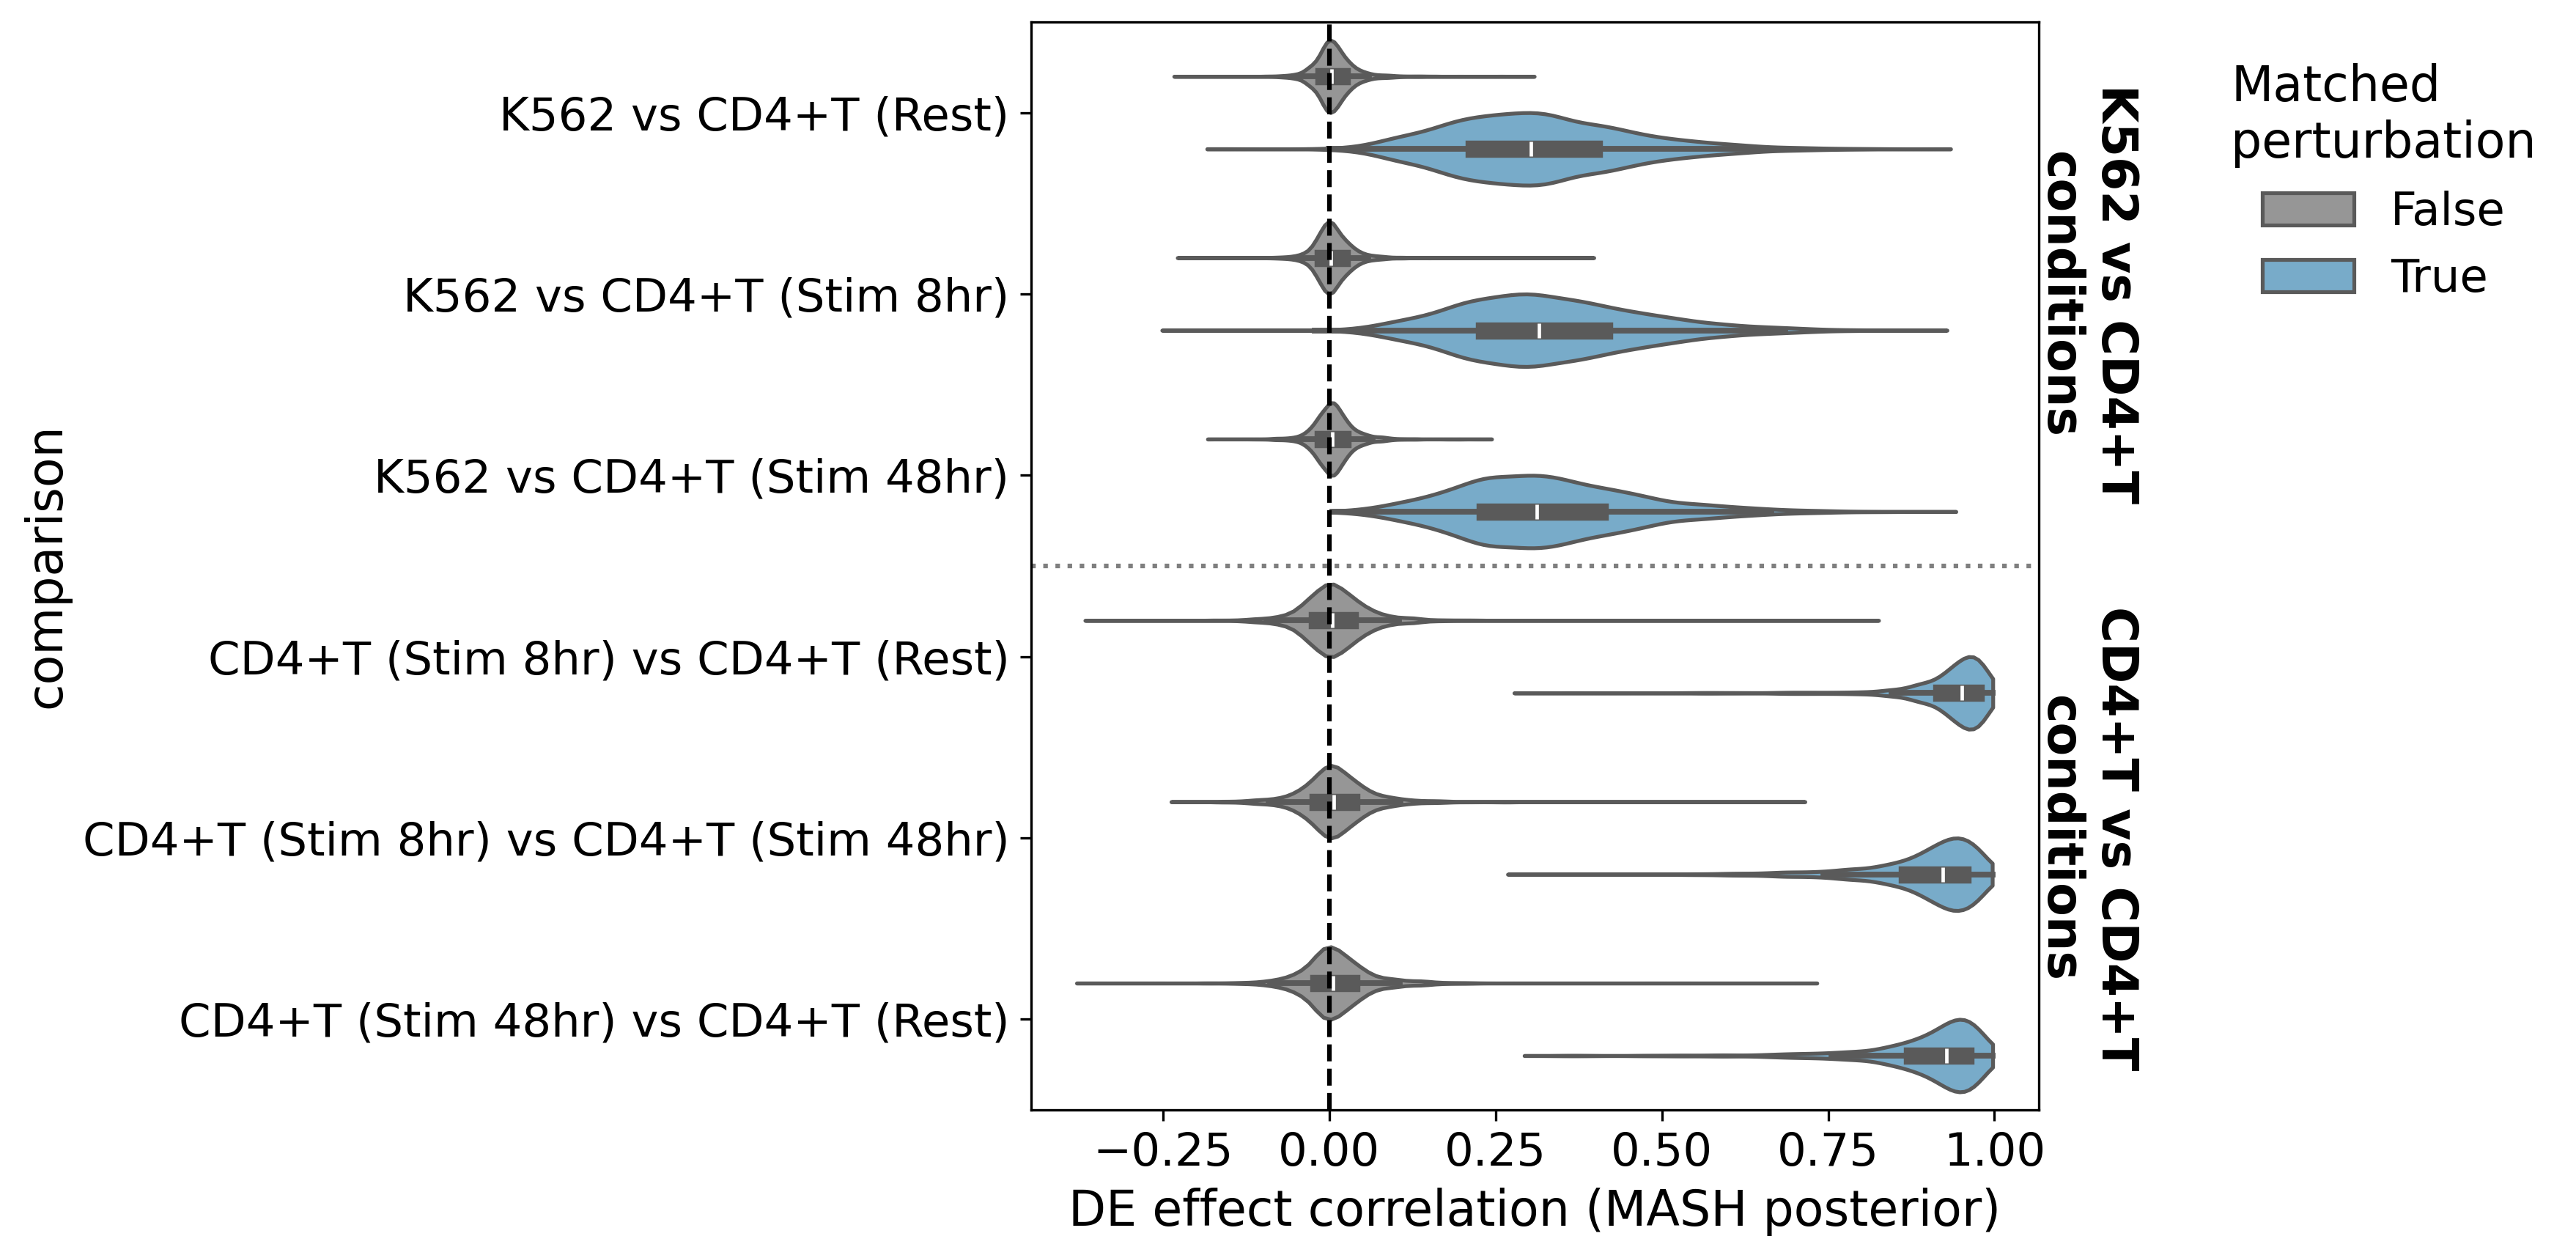

In [69]:
# # Get top 3 and bottom 3 values for each comparison
# top_bottom = pd.concat([
#     correlation_results.groupby('comparison').apply(lambda x: x.nlargest(10, 'pearson_r')['Perturbation']),
#     # correlation_results.groupby('comparison').apply(lambda x: x.nsmallest(3, 'pearson_r')['Perturbation'])
# ])
# top_bottom
# # .sort_values(['comparison', 'pearson_r'], ascending=[True, False])
# # display(top_bottom[['comparison', 'Perturbation', 'pearson_r']])

In [70]:
# correlation_results = pd.concat([v.assign(comparison=k) for k,v in comparison_results.items()])

# # Create figure with 3 subplots in one row
# fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# # Plot each comparison in its own subplot
# for i, comparison in enumerate(correlation_results.comparison.unique()):
#     ax = axes[i]
#     mask = correlation_results['comparison'] == comparison
    
#     # Plot random distributions
#     for col in ['random_r1', 'random_r2', 'random_r3']:
#         data = correlation_results[mask][col]
#         sns.kdeplot(
#             data=data,
#             ax=ax,
#             color='#7f7f7f',
#             linewidth=1,
#             alpha=0.3,
#             label='Unmatched perturbation' if col == 'random_r1' else '_nolegend_',
#             bw_adjust=0.5,
#             common_norm=True,
#             clip=(data.min(), data.max())
#         )

#     # Plot main distribution  
#     data = correlation_results[mask]['pearson_r']
#     sns.kdeplot(
#         data=data,
#         ax=ax,
#         color='#8B0000',
#         linewidth=3,
#         label='Matched perturbation',
#         bw_adjust=0.5,
#         common_norm=False,
#         clip=(data.min(), data.max())
#     )
#     # Add vertical lines
#     median = correlation_results[mask]['pearson_r'].median()
#     ax.axvline(median, color='#8B0000', linestyle='dashed', linewidth=2, label=f'Median')
#     ax.axvline(0, color='#7f7f7f', linestyle='dotted', linewidth=2)

#     # Styling
#     ax.set_xlabel('DE effect correlation\n(MASH posterior)', fontsize=16)
#     if i == 0:
#         ax.set_ylabel('Density', fontsize=16)
#     else:
#         ax.set_ylabel('', fontsize=12)
#     ax.set_title(comparison.replace('_', ' '), fontsize=16)
#     if i == 3:
#         ax.legend(fontsize=16, bbox_to_anchor=(1.1, 1), frameon=False)
#     ax.grid(alpha=0.3)

# fig.tight_layout()
# fig.savefig('K562_vs_CD4_MASH_correlation.png')
# fig.savefig('K562_vs_CD4_MASH_correlation.pdf')
# fig.show()

In [71]:
# ## Load IL2 hits
# schmidt_crispri = pd.read_excel('../../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
# schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# # Create dictionary where key is hit type and values are lists of genes
# hit_type_dict = {}
# for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
#     hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()

# pl_df = correlation_results.pivot(columns='comparison', index='Perturbation', values='pearson_r')

# # Create figure with gridspec for main scatter plot and marginal distributions
# fig = plt.figure(figsize=(7, 7))
# gs = fig.add_gridspec(4, 4)  # Increase grid divisions for finer control
# ax_main = fig.add_subplot(gs[1:, :-1])
# ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
# ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # Reduced height by using only 1/4 of vertical space

# # Create color palette for hit types
# hit_colors = {
#     'Negative Hit': '#e41a1c',
#     'Positive Hit': '#377eb8',
#     # 'Both': '#4daf4a'
# }

# # Plot non-hit genes in gray first
# non_hits = pl_df.index[~pl_df.index.isin([gene for genes in hit_type_dict.values() for gene in genes])]
# sns.scatterplot(data=pl_df.loc[non_hits], x='CD4+T (Stim 48hr) vs CD4+T (Rest)', y='K562_vs_Stim', 
#                 color='lightgray', s=10, linewidth=0, alpha=0.5, ax=ax_main, label='Non-hits')

# # Plot hits with different colors
# for hit_type, genes in hit_type_dict.items():
#     hit_genes = [g for g in genes if g in pl_df.index]
#     if hit_genes:
#         sns.scatterplot(data=pl_df.loc[hit_genes], x='CD4+T (Stim 48hr) vs CD4+T (Rest)', y='K562_vs_Stim',
#                        color=hit_colors[hit_type], s=30, linewidth=0, alpha=0.8, 
#                        ax=ax_main, label=hit_type)

# # Add diagonal line
# lims = [
#     min(pl_df['CD4+T (Stim 48hr) vs CD4+T (Rest)'].min(), pl_df['K562_vs_Stim'].min()),
#     max(pl_df['CD4+T (Stim 48hr) vs CD4+T (Rest)'].max(), pl_df['K562_vs_Stim'].max())
# ]
# ax_main.plot(lims, lims, 'k--', alpha=0.5, zorder=0)
# ax_main.set_xlabel('Stim8hr vs Rest DE effect (MASH posterior)')
# ax_main.set_ylabel('Stim8hr vs K562 DE effect (MASH posterior)')

# # Annotate perturbations with low Stim_vs_Rest correlation using adjustText
# from adjustText import adjust_text

# low_corr_mask = pl_df['Stim_vs_Rest'] < 0.5
# texts = []
# for idx in pl_df[low_corr_mask].index:
#     texts.append(ax_main.text(pl_df.loc[idx, 'Stim_vs_Rest'], 
#                             pl_df.loc[idx, 'K562_vs_Stim'],
#                             idx,
#                             fontsize=8,
#                             bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')))

# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5), ax=ax_main)

# # Add marginal histograms
# ax_top.hist(pl_df['Stim_vs_Rest'], bins=30, alpha=0.5)
# ax_top.axvline(pl_df['Stim_vs_Rest'].mean(), color='black', linestyle=':', alpha=0.5)

# ax_right.hist(pl_df['K562_vs_Stim'], bins=30, alpha=0.5, orientation='horizontal')
# ax_right.axhline(pl_df['K562_vs_Stim'].mean(), color='black', linestyle=':', alpha=0.5)

# # Remove redundant labels from marginal plots
# ax_top.set_xlabel('')
# ax_right.set_ylabel('')

# plt.tight_layout()

In [116]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**GO_BP_sets, **KEGG_sets}

# Top correlations in K562 comparison
top_20_threshold = correlation_results[correlation_results.comparison.str.contains('K562')]['pearson_r'].quantile(0.8)
correlated_gs = correlation_results[correlation_results.comparison.str.contains('K562') & 
                                (correlation_results['pearson_r'] >= top_20_threshold)].Perturbation.unique()
correlated_gs = correlated_gs.tolist()
all_gs = correlation_results.Perturbation.unique().tolist()
enr = gp.enrichr(gene_list=correlated_gs,
                gene_sets=GENESETS,
                organism='Human', 
                cutoff=1,
                background=all_gs,
                outdir=f'results/test_enrichr/K562_top_correlations/',
                no_plot=True
                )


k562_high_corr_terms = enr.results[['Term', 'P-value', 'Adjusted P-value', 'Genes']].sort_values('Adjusted P-value')

# Low correlations in CD4 comparison
bottom_20_threshold = correlation_results[~correlation_results.comparison.str.contains('K562')]['pearson_r'].quantile(0.1)
correlated_gs = correlation_results[~correlation_results.comparison.str.contains('K562') & 
                                (correlation_results['pearson_r'] <= bottom_20_threshold)].Perturbation.unique()
correlated_gs = correlated_gs.tolist()
all_gs = correlation_results.Perturbation.unique().tolist()
enr = gp.enrichr(gene_list=correlated_gs,
                gene_sets=GENESETS,
                organism='Human', 
                cutoff=1,
                background=all_gs,
                outdir=f'results/test_enrichr/CD4_bottom_correlations/',
                no_plot=True
                )

cd4_low_corr_terms = enr.results[['Term', 'P-value', 'Adjusted P-value', 'Genes']].sort_values('Adjusted P-value')
cd4_low_corr_terms.head()


,Term,P-value,Adjusted P-value,Genes
623,Mitochondrial Respiratory Chain Complex Assemb...,8.475967e-07,0.001740,ECSIT;AIFM1;COX17;COA3;NDUFC2;DMAC2;NDUFAF3;OX...
624,Mitochondrial Respiratory Chain Complex I Asse...,6.078160e-05,0.023418,ECSIT;NDUFC2;DMAC2;NDUFAF3;OXA1L;NDUFS5;NDUFB7...
677,NADH Dehydrogenase Complex Assembly (GO:0010257),6.078160e-05,0.023418,ECSIT;NDUFC2;DMAC2;NDUFAF3;OXA1L;NDUFS5;NDUFB7...
1413,Pyruvate Metabolic Process (GO:0006090),6.844114e-05,0.023418,HK2;ENO2;GPI;PGK1;PKM;PDHA1;PGAM1;SRR
965,Parkinson disease,5.193501e-05,0.023418,UBE2G1;NDUFB10;UQCRQ;UQCRB;CYCS;CYC1;COX6C;NDU...


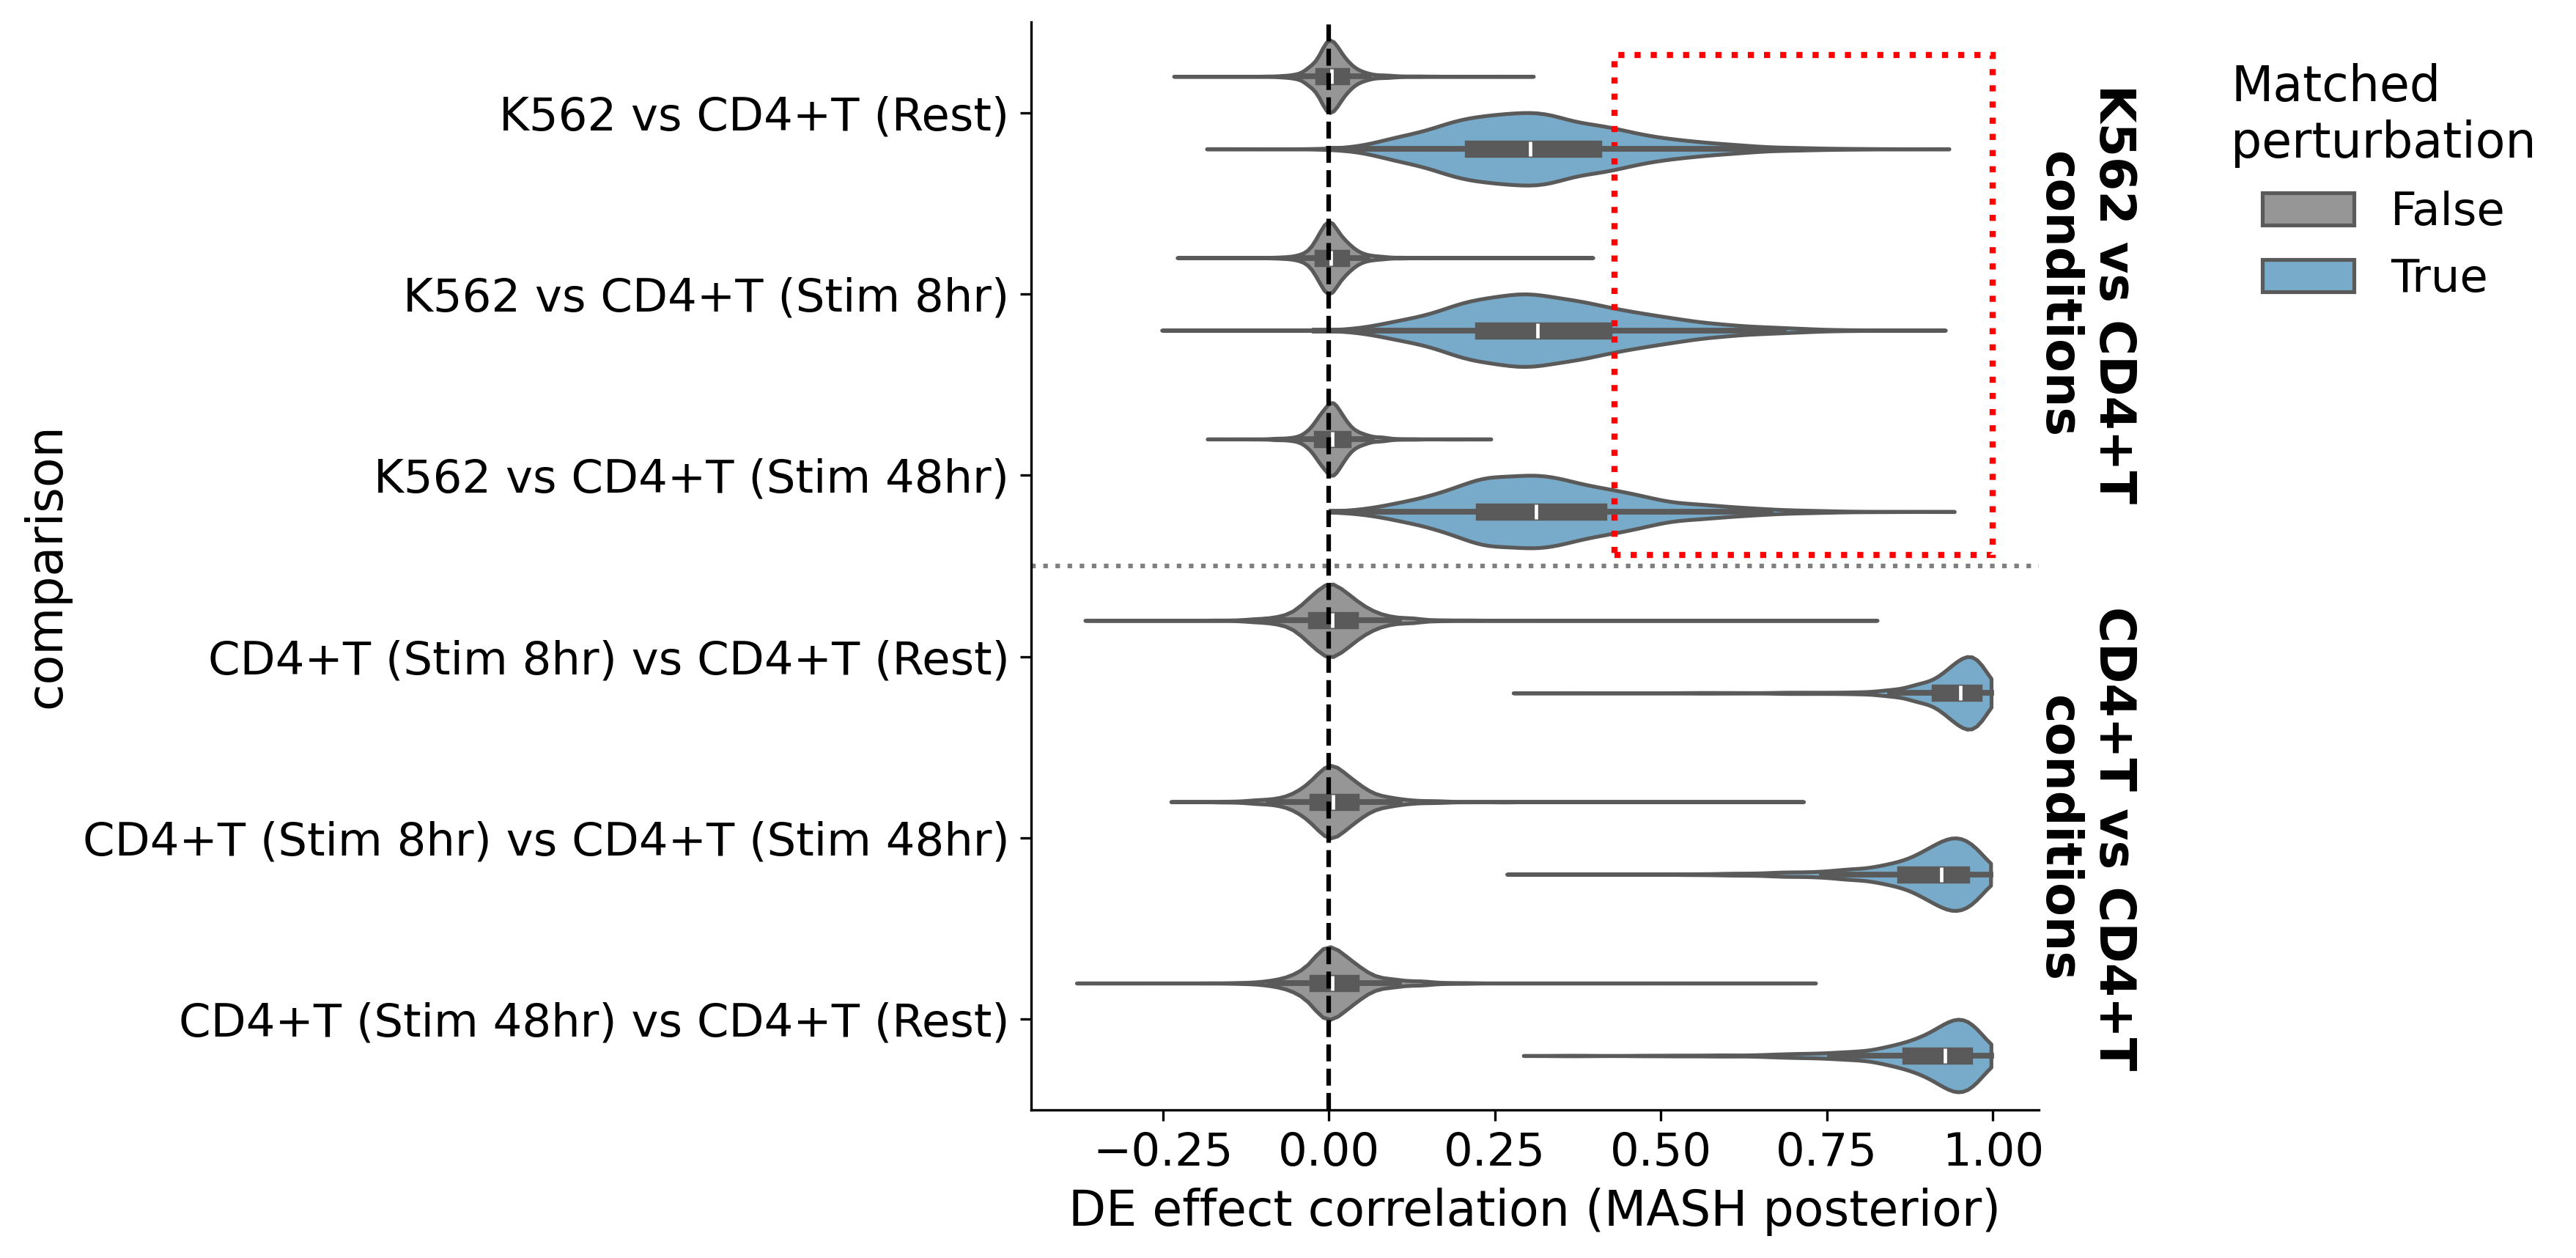

In [134]:
pl_n_de_genes_ct = n_de_genes_ct.copy()
pl_n_de_genes_ct.columns = [f'n_degs_{x}' for x in pl_n_de_genes_ct.columns]
pl_n_de_genes_ct = pl_n_de_genes_ct.reset_index().rename(columns={'target_contrast': 'Perturbation'})

correlation_results = pd.merge(correlation_results, pl_n_de_genes_ct, how='left')

pl_correlation_df = correlation_results[['Perturbation', 'pearson_r', 'random_r1', 'comparison']].melt(id_vars=['Perturbation', 'comparison'], value_name='r', var_name='perturbation_pair')
pl_correlation_df['perturbation_pair'] = np.where(pl_correlation_df['perturbation_pair'] == 'pearson_r', True, False)

matched_target_palette = palettes['matched_targets']
plt.figure(figsize=(12,6))
ax = plt.gca()
sns.violinplot(data=pl_correlation_df, y='comparison', x='r', hue='perturbation_pair', cut=0, density_norm='width', palette=matched_target_palette);
plt.axvspan(top_20_threshold, 1, ymin=0.51, ymax=0.97, facecolor='none', edgecolor='red', linestyle=':', alpha=1, linewidth=2)
plt.axvline(0, linestyle='--', color='black')

y_values = pl_correlation_df['comparison'].unique()
plt.axhline(y=2.5, color='black', linestyle=':', alpha=0.5)
plt.text(1.14, y_values[4], 'CD4+T vs CD4+T\nconditions', ha='center', va='center', rotation=270, weight='bold')
plt.text(1.14, y_values[1], 'K562 vs CD4+T\nconditions', ha='center', va='center', rotation=270, weight='bold')

plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Matched\nperturbation', frameon=False)
sns.despine()
plt.xlabel('DE effect correlation (MASH posterior)')
plt.savefig('./results/K562_effect_size_correlation.pdf')
plt.savefig('./results/K562_effect_size_correlation.png')

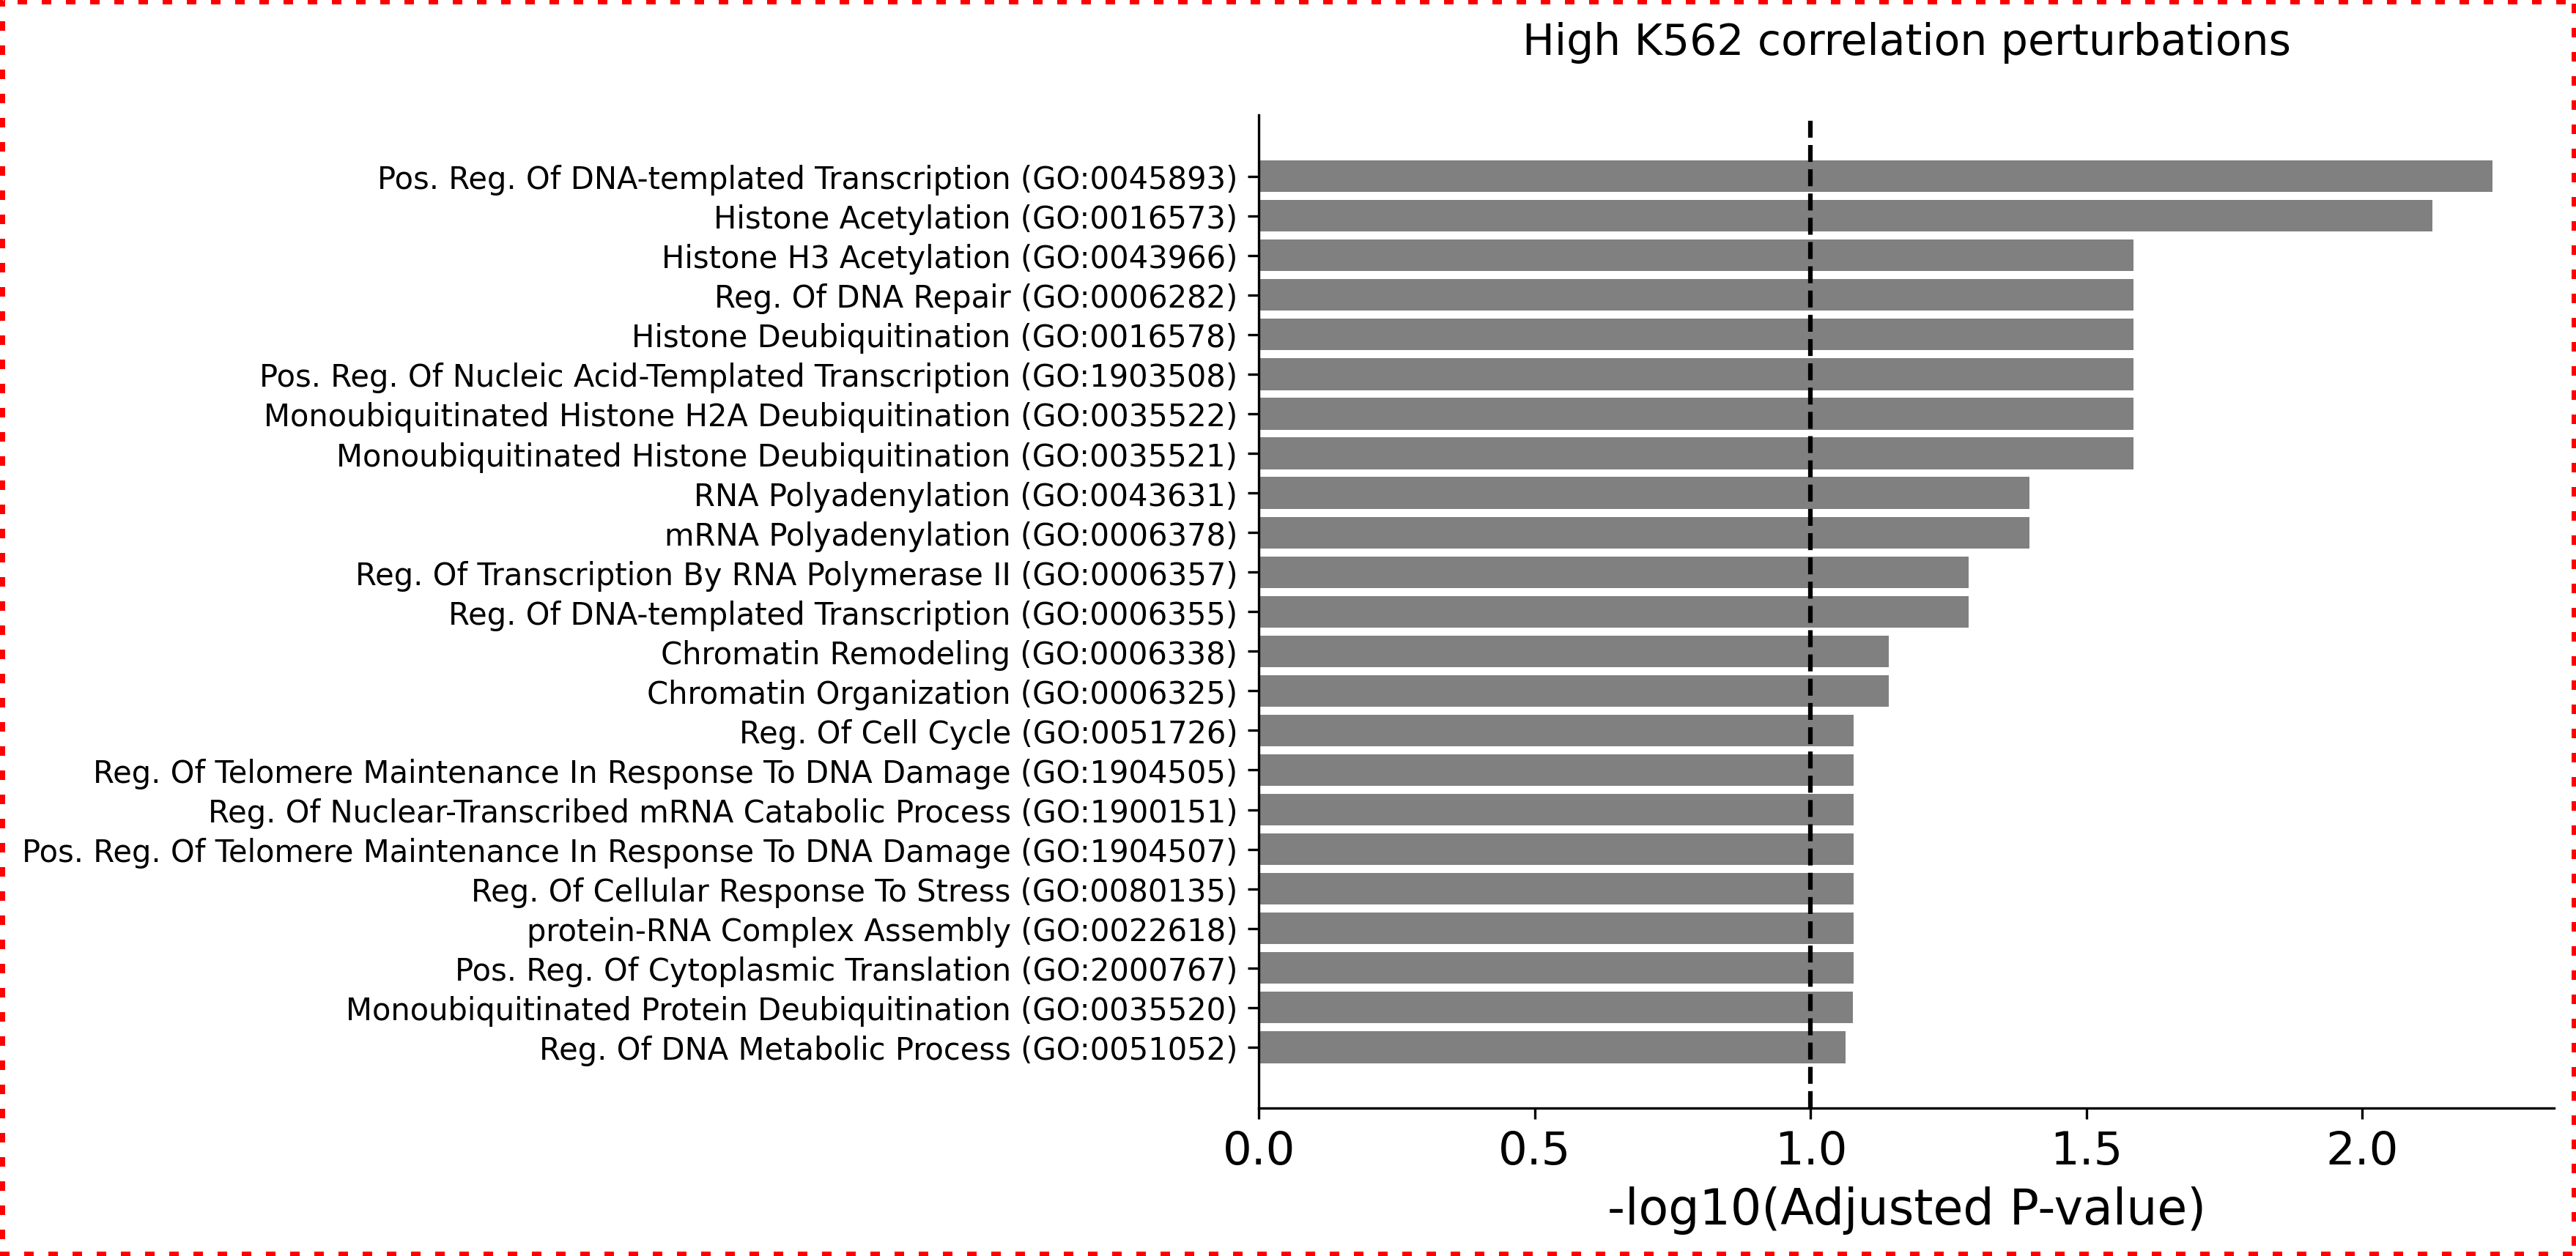

In [177]:
signif_terms = k562_high_corr_terms[k562_high_corr_terms['Adjusted P-value'] < 0.1].copy()
signif_terms = signif_terms.sort_values('Adjusted P-value', ascending=False)
signif_terms['-log10(adj P)'] = -np.log10(signif_terms['Adjusted P-value'])

signif_terms['Term'] = signif_terms['Term'].str.replace('Regulation', 'Reg.')
signif_terms['Term'] = signif_terms['Term'].str.replace('Positive', 'Pos.')
signif_terms['Term'] = signif_terms['Term'].str.replace('Negative', 'Neg.')
signif_terms['Term'] = np.where(signif_terms['Term'].str.contains(','), signif_terms['Term'].str.split(',').str[0] + ' (GO:' + signif_terms['Term'].str.split(',').str[1].str.split(' \(GO:').str[1],  signif_terms['Term'])

plt.figure(figsize=(12, 6))
ax = plt.gca()

bars = plt.barh(range(len(signif_terms)), signif_terms['-log10(adj P)'], color='grey')

plt.yticks(range(len(signif_terms)), signif_terms['Term'], fontsize=10)
plt.xlabel('-log10(Adjusted P-value)')
plt.axvline(x=1, color='black', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('High K562 correlation perturbations', pad=20, fontsize=14)

# Add red dotted border around entire figure
# ax.patch.set_edgecolor('red')
# ax.patch.set_linewidth(5)

fig = plt.gcf()
fig.patch.set_edgecolor('red')
fig.patch.set_linewidth(3)
fig.patch.set_linestyle(':')

plt.tight_layout()
plt.savefig('./results/K562_top_corr_GO_terms.pdf')
plt.savefig('./results/K562_top_corr_GO_terms.png')